# STA 141B: Homework 5
Winter 2018

# E-Shen Wu 914526861

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [39]:
import pandas as pd
import numpy as np

import geopandas as gpd
import osmnx as ox
import shapely.geometry as geom 

import sqlalchemy as sqla

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [40]:
sqlite_file = '/Users/foxeshen/OneDrive - g.ntu.edu.tw/141BHW/141b-hw5-foxeshen/sf_data.sqlite'
sf_conn = sqla.create_engine('sqlite:///' + sqlite_file)

In [41]:
pd.read_sql("SELECT * FROM sqlite_master", sf_conn)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [44]:
permits = pd.read_sql_query("select * FROM mobile_food_permits where Status == 'APPROVED' ",sf_conn)
permits.head(5)

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
2,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0024,APPROVED,"Off the Grid Services, LLC",Truck,Everything,0,2016-03-17 12:00:00,2017-03-15 12:00:00
4,16MFF-0036,APPROVED,Roadside Rotisserie Corporation / Country Grill,Truck,Rotisserie Chicken: Ribs: Kickass Salad: Potat...,0,2016-03-10 12:00:00,2017-03-15 12:00:00


In [45]:
schedule = pd.read_sql_query("select * FROM mobile_food_schedule",sf_conn)
schedule.head(5)

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10


In [51]:
resutlt = pd.read_sql("""select T2.permit, 
                         T2.status,
                         count(distinct T1.locationid) as Count,
                         Applicant as Vendor_Name
                         from (mobile_food_schedule as T1 
                               left join 
                               mobile_food_permits as T2
                               on T1.permit = T2.permit)                         
                         where T2.status = 'APPROVED'
                         group by T2.permit 
                         order by count DESC
                         """,sf_conn)
resutlt.head(5)

,permit,Status,Count,Vendor_Name
0,16MFF-0051,APPROVED,23,Park's Catering
1,16MFF-0037,APPROVED,17,D & T Catering
2,16MFF-0027,APPROVED,13,F & C Catering
3,16MFF-0069,APPROVED,10,Munch A Bunch
4,17MFF-0125,APPROVED,7,BH & MT LLC


The mobile food vendor(s) '16MFF-0051' sells at the most locations(23).

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 2 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make maps for questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [52]:
#1.Which parts of the city are the most and least expensive?
mediansolddata=pd.read_sql_query("select * FROM zillow",sf_conn)
mediansolddata = mediansolddata[np.isfinite(mediansolddata['MedianSoldPricePerSqft_AllHomes'])]
median=mediansolddata[['RegionName','Date','MedianSoldPricePerSqft_AllHomes']]
median['Date'] = pd.to_datetime(median['Date'])

RegionName=median['RegionName'].unique().tolist()
all_data = pd.DataFrame()
for id in  RegionName:
    df=median.loc[median['RegionName'] == id]
    df=df.loc[df['Date']==df['Date'].max()]
    all_data = all_data.append(df,ignore_index=True)   
all_data=all_data.sort_values(['MedianSoldPricePerSqft_AllHomes'])
all_data

/var/folders/32/9jvyc3s955d5cqm8xnz6g8dm0000gn/T/ipykernel_51098/3052460201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  median['Date'] = pd.to_datetime(median['Date'])


,RegionName,Date,MedianSoldPricePerSqft_AllHomes
15,94124,2016-05-01,583.533173
3,94080,2016-06-01,628.616900
20,94132,2016-06-01,639.163277
14,94134,2016-05-01,650.256100
4,94112,2016-07-01,755.397000
24,94108,2004-11-01,769.973545
2,94122,2016-07-01,798.023500
7,94121,2016-06-01,826.116300
11,94116,2016-06-01,840.558200
23,94111,2007-09-01,901.804100


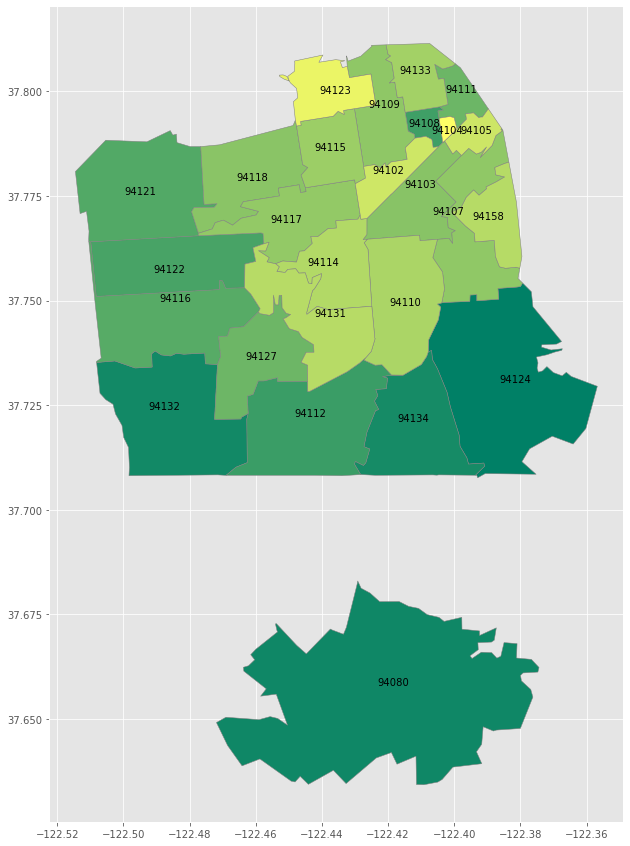

In [54]:
zipcode = gpd.read_file("/Users/foxeshen/OneDrive - g.ntu.edu.tw/141BHW/141b-hw5-foxeshen/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")
zipcode['RegionName']=zipcode['ZCTA5CE10'].astype(int)

mergedata=pd.merge(all_data,zipcode,on='RegionName', how='inner')
mergedata['RegionName']=mergedata['RegionName'].astype(str)
mergedata = gpd.GeoDataFrame(mergedata)

ax=mergedata.plot(column='MedianSoldPricePerSqft_AllHomes', cmap='summer', edgecolor = "gray",figsize = (15, 15))

def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.RegionName, xy = coords, horizontalalignment = "center")    

mergedata.apply(add_label, axis = 1)
plt.show()

In the table, we can see that postcode areas "94124" is the least expensive part in the city and postcode areas "94104" is the most expensive part in the city.
In the plot, the bright green areas represent more expensive and vice versa.  

Text(0.5, 1.0, 'Number of Crime by area')

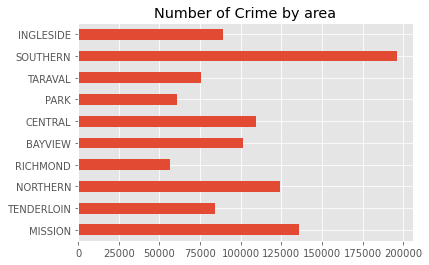

In [55]:
#2.Which parts of the city are the most dangerous (and at what times)?
crime=pd.read_sql_query("select * FROM crime",sf_conn)
(crime['PdDistrict']
 .value_counts(sort=False)
 .plot.barh()
 .set_title('Number of Crime by area')
)

In this bar plot, we count the number of crime group by PdDistrict and find out that crimes are most likely to occur at "Southern".

/var/folders/32/9jvyc3s955d5cqm8xnz6g8dm0000gn/T/ipykernel_51098/3533945876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOUTHERNcrime['Datetime']=pd.to_datetime(SOUTHERNcrime['Datetime'])
/var/folders/32/9jvyc3s955d5cqm8xnz6g8dm0000gn/T/ipykernel_51098/3533945876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOUTHERNcrime['hour'] = SOUTHERNcrime['Datetime'].dt.hour


Text(0.5, 1.0, 'When crime occur')

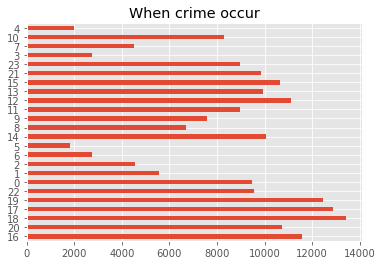

In [23]:
SOUTHERNcrime=crime.loc[crime['PdDistrict'] == 'SOUTHERN']
SOUTHERNcrime
SOUTHERNcrime['Datetime']=pd.to_datetime(SOUTHERNcrime['Datetime'])
SOUTHERNcrime['hour'] = SOUTHERNcrime['Datetime'].dt.hour
SOUTHERNcrime
(SOUTHERNcrime['hour']
 .value_counts(sort=False)
 .plot.barh()
 .set_title('When crime occur')
)

In this plot, it shows that crimes occur most frequently at 6 p.m in southern.

In [58]:
#3.Are noise complaints and mobile food vendors related?
noise = pd.read_sql_query("""select * from noise""",sf_conn)
noise.head()

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
0,5130305,other_excessive_noise,Not associated with a specific address,None,2015-09-25 00:29:33,NaN,NaN
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232


In [60]:
#noise by mobile
noise_type = pd.read_sql("""select Type, Datetime, Type
                            from noise
                            where Type = 'mobile_food_facility'
                         """,sf_conn)
noise_type # total 7 

,Type,Datetime,Type
0,mobile_food_facility,2016-10-08 15:39:50,mobile_food_facility
1,mobile_food_facility,2016-06-25 23:45:10,mobile_food_facility
2,mobile_food_facility,2016-08-30 21:57:31,mobile_food_facility
3,mobile_food_facility,2016-10-04 17:43:25,mobile_food_facility
4,mobile_food_facility,2015-09-02 10:57:17,mobile_food_facility
5,mobile_food_facility,2016-03-01 06:24:48,mobile_food_facility
6,mobile_food_facility,2016-11-03 16:41:55,mobile_food_facility


In [71]:
#all noise time
noise_time = pd.read_sql("""select 
                            strftime("%H",Datetime) as Hour,
                            count(CaseID) as Count
                            from noise
                            group by Hour 
                            order by Hour asc
                            """,sf_conn)
noise_time.head(24)

,Hour,Count
0,00,252
1,01,177
2,02,112
3,03,97
4,04,59
5,05,81
6,06,163
7,07,186
8,08,235
9,09,260


<AxesSubplot:xlabel='Hour', ylabel='Count'>

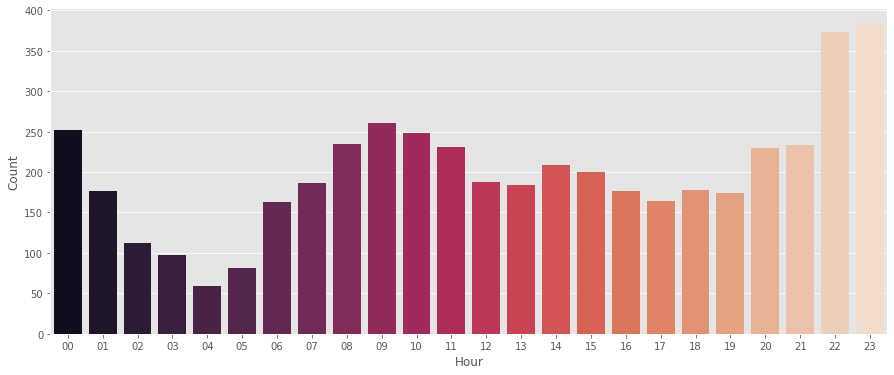

In [74]:
f, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
sns.barplot( x='Hour' , y='Count', data = noise_time, palette="rocket",ax=ax1)

In [77]:
# Map
Inglat = [ geom.Point (x) for x in zip (noise.Lon, noise.Lat)]
Noise_Geo = gpd.GeoDataFrame(noise, geometry = Inglat)
MobilFood_Noise_Geo = Noise_Geo.loc [Noise_Geo.Type == 'mobile_food_facility']

FoodLoc = pd.read_sql_query("""select * from mobile_food_locations""",sf_conn)
Inglat = [ geom.Point (x) for x in zip (FoodLoc.Longitude, FoodLoc.Latitude)]
Food_Loc_Geo = gpd.GeoDataFrame(FoodLoc, geometry = Inglat)

In [78]:
# SF shape
SF_shape = gpd.read_file("/Users/foxeshen/OneDrive - g.ntu.edu.tw/141BHW/141b-hw5-foxeshen/SF Find Neighborhoods/geo_export_483c48dc-f1ca-4509-aa23-a734c8683dc4.shp")

(37.7, 37.84)

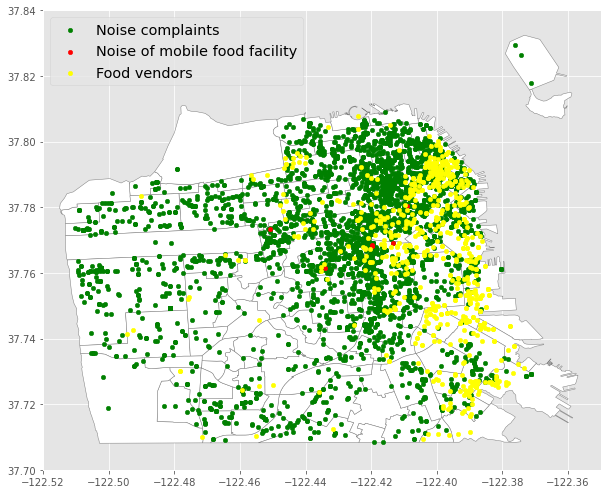

In [85]:
# Plotting
ax = SF_shape.plot(color ="white" , edgecolor ="gray" , figsize = (10, 10))

Noise_Geo.plot(ax= ax, color= "green", markersize=20, label="Noise complaints")
MobilFood_Noise_Geo.plot(ax = ax, color ='red', markersize=20, label="Noise of mobile food facility" )
Food_Loc_Geo.plot(ax= ax, color= 'yellow', markersize=20, label="Food vendors")

plt.legend(loc=2, fontsize = 'x-large')

ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.70, 37.84])

In this plot, yellow points represent the location of mobile food vendors and green points represent the location of 
noise complaints. We can see that most of yellow points are located at right side(east) of the city. There is a cluster 
of green points located at upper right coorner. It seems that the location of food vendors and the location of noise 
complaints are unrelated.